# Fading differentation
Philippes idea: Differentiation markers are gradually lost going from normal to metaplasia to tumor


In [1]:
from crukiopy_release.datatools import read_metadata, adata_from_gs, create_samplefile
from crukiopy_release.celltype_mappings import annotate_coarse_celltype
from crukiopy_release.colormaps import color_dict_diagnosis
import scanpy as sc
from tidyverse.dummy import *

Importing tidyverse


In [2]:
A = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

In [3]:
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict, read_metadata
A = fix_diagnosis(A)
df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

In [4]:
A.obs['celltype_split'] = annotate_coarse_celltype(A, 'leiden')
A.obs.loc[A.obs.leiden=="13", 'celltype_split'] = "Myofibroblast"
A.obs.loc[A.obs.leiden=="19", 'celltype_split'] = "Neutrophil"
A.obs.loc[A.obs.leiden=="15", 'celltype_split'] = "NK"

In [5]:
philippes_markers = [
    'MUC5AC',
    'FCGBP',
    'CLCA1',
    'MUC2',
    'SPINK4',
    'ITLN1',
    'ZG16',
    'REG4',
    'GKN2',
    'LIPF',
    'PGC',
    'PGA3',
    'PGA4',
    'ANPEP',
    'CHIA',
    'ATP4A',
    'ATP4B',
    'KCNE2',
    'PLA2G2A',
    'MUC6',
    'VIL1',
    'CDH17',
    'PHGR1',
    'KRT20',
    'CHGA',
    'GFRA3',
    'OLFM4',
    'AGT',
#     'LAMA3',
#     'LAMA4',
#     'LAMA5',
#     'LAMB1',
#     'LAMB2',
#     'LAMB3',
#     'LAMC1',
#     'LAMC2',
]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'diagnosis' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_diagnosis' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype_split' as categorical


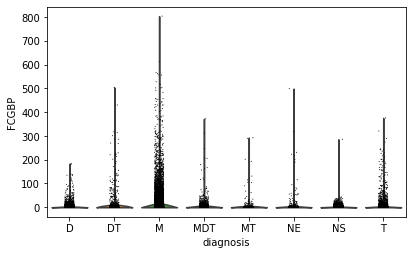

In [6]:
A_epi = A[A.obs.celltype_split=="Epithelial cells"]
sc.pl.violin(A_epi[:,'FCGBP'], keys=['FCGBP'], groupby='diagnosis')

In [7]:
O = A_epi.obs.copy()
# O['gene'] = A_epi[:, 'MUC5AC'].X.A.flatten()
O['gene'] = A_epi[:, 'FCGBP'].X.A.flatten()

O['diagnosis_simple'] = O['diagnosis']
O['diagnosis_simple'].replace({'MT': 'T','MDT': 'T','DT':'T'}, inplace=True)
O['diagnosis_simple'] = pd.Categorical(O['diagnosis_simple'], ['NE','M','D','T','NS'])
O['gene_norm'] = O['gene'] / O['n_molecules']

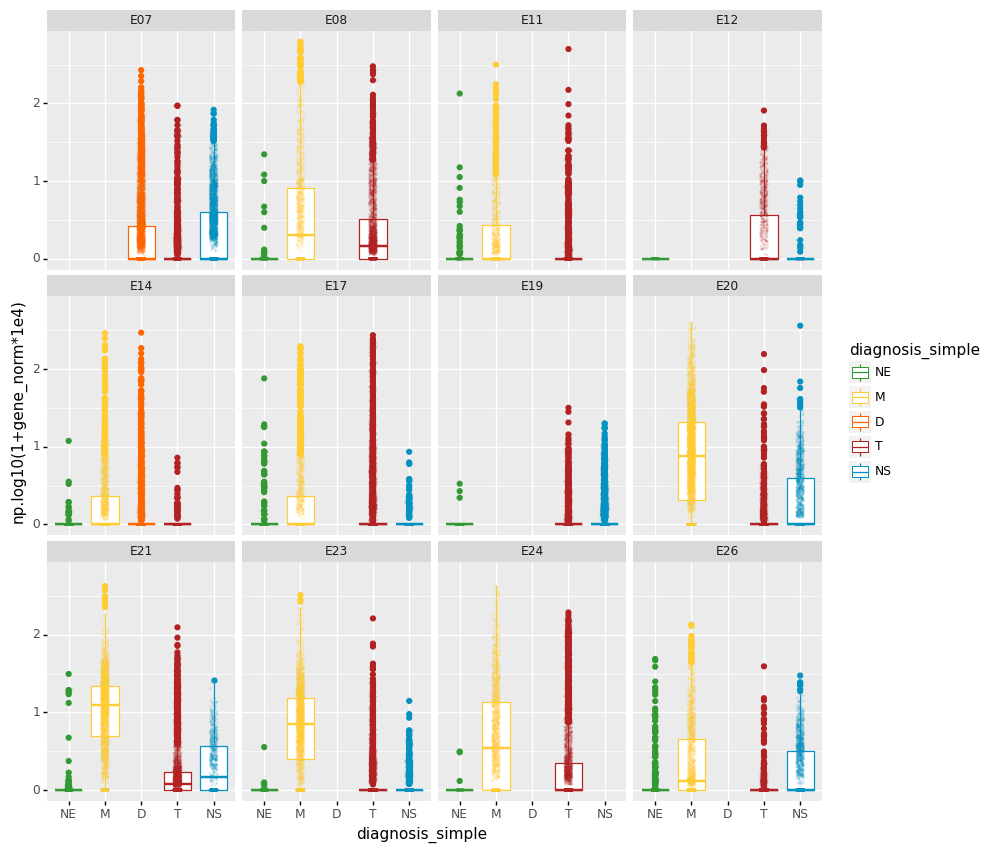

<ggplot: (8757003781873)>

In [8]:
# pn.ggplot(O, pn.aes('diagnosis_simple', 'np.log10(1+gene_norm*10000)', color='diagnosis')) \
pn.ggplot(O, pn.aes('diagnosis_simple', 'np.log10(1+gene_norm*1e4)', color='diagnosis_simple')) \
+ pn.geom_boxplot() + pn.geom_jitter(size=0.1, width=0.1, alpha=0.1)  + pn.facet_wrap('patient')+ pn.scale_color_manual(color_dict_diagnosis) + pn.theme(figure_size=(10,10))

## Due to sample impurity, the whole thing gets a little difficult
But we can define NS clusters, M clusters, D/t clusters looking at the UMAP layout

Cluster 27: not clear where to put it: Its mostly from metaplastic samples of E17, but is has slight CNV changes (looks like a p53 del)


In [9]:
clusters_NS = ['45','5','20','17','34','8','43','30']
clusters_M = ['0','35','32','7' '27']
clusters_NE = ['25','23']
clusters_DT = ['9','11','18','21','10','31','39','37','26','29', ]# '27'

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical
... storing 'celltype_split' as categorical


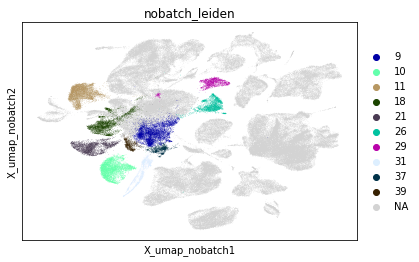

In [10]:
sc.pl.embedding(A, basis='X_umap_nobatch', 
                color=['nobatch_leiden'], groups=clusters_DT)

In [11]:
def _tmp(leiden):
    if leiden in clusters_NS:
        return 'NS'
    if leiden in clusters_NE:
        return 'NE'
    if leiden in clusters_M:
        return 'M'
    if leiden in clusters_DT:
        return 'DT'
    return 'NA'
    
A.obs['diagnosis_cluster'] = A.obs.nobatch_leiden.apply(_tmp)

# from differentiated to less differetiated
A.obs['diagnosis_cluster'] = pd.Categorical(A.obs['diagnosis_cluster'], ['NE','NS','M','DT', 'NA'])

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


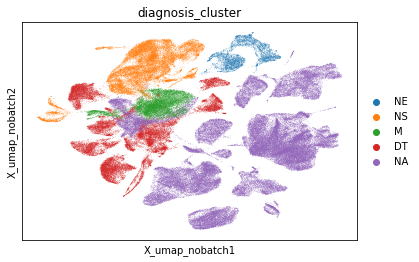

In [12]:
sc.pl.embedding(A, basis='X_umap_nobatch', 
                color=['diagnosis_cluster'])

In [14]:
A._inplace_subset_obs(A.obs.celltype_split=="Epithelial cells")
A_epi = A
O = A_epi.obs[['diagnosis_cluster','n_molecules', 'patient']].copy()
O['gene'] = A_epi[:, 'MUC5AC'].X.A.flatten()
# O['gene'] = A_epi[:, 'FCGBP'].X.A.flatten()
# O['gene'] = A_epi[:, 'MUC2'].X.A.flatten()
# O['gene'] = A_epi[:, 'CDH17'].X.A.flatten()
# O['gene'] = A_epi[:, 'ZG16'].X.A.flatten()

O['gene_norm'] = O['gene'] / O['n_molecules']

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


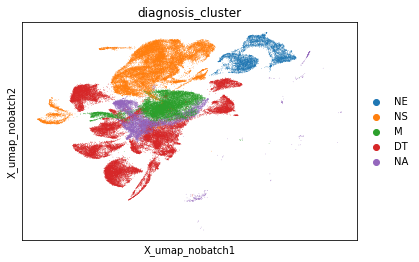

In [15]:
sc.pl.embedding(A_epi, basis='X_umap_nobatch', 
                color=['diagnosis_cluster'])

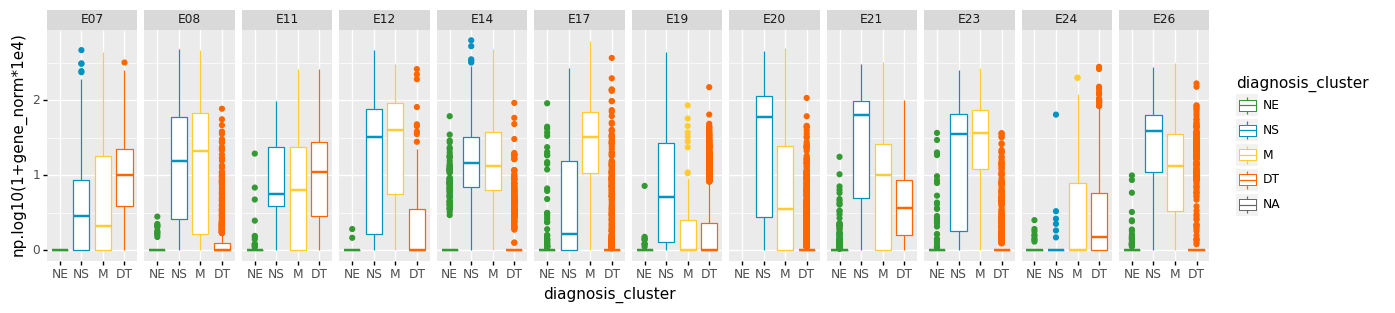

<ggplot: (8757004208441)>

In [16]:
#  + pn.geom_jitter(size=0.1, width=0.1, alpha=0.1)
# pn.ggplot(O.query('diagnosis_cluster!="NA"'), pn.aes('diagnosis_cluster', 'np.log10(gene)', color='diagnosis_cluster')) \

pn.ggplot(O.query('diagnosis_cluster!="NA"'), pn.aes('diagnosis_cluster', 'np.log10(1+gene_norm*1e4)', color='diagnosis_cluster')) \
+ pn.geom_boxplot() + pn.facet_wrap('patient', ncol=12)\
+ pn.scale_color_manual(color_dict_diagnosis) + pn.theme(figure_size=(15,3))

In [17]:
DDDD = []
for g in tqdm.tqdm(philippes_markers):
    O = A_epi.obs[['diagnosis_cluster','n_molecules', 'patient']].copy()
    O['expression'] = A_epi[:, g].X.A.flatten()
    O['expression_norm'] = O['expression'] / O['n_molecules']
    
    _df = pd.crosstab(O.diagnosis_cluster, O.patient, values=O.expression_norm, aggfunc=np.mean).reset_index().melt(id_vars=['diagnosis_cluster'])
    _df['genename'] = g
    DDDD.append(_df)
DDDD = pd.concat(DDDD)

100%|██████████| 28/28 [00:29<00:00,  1.04s/it]


/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


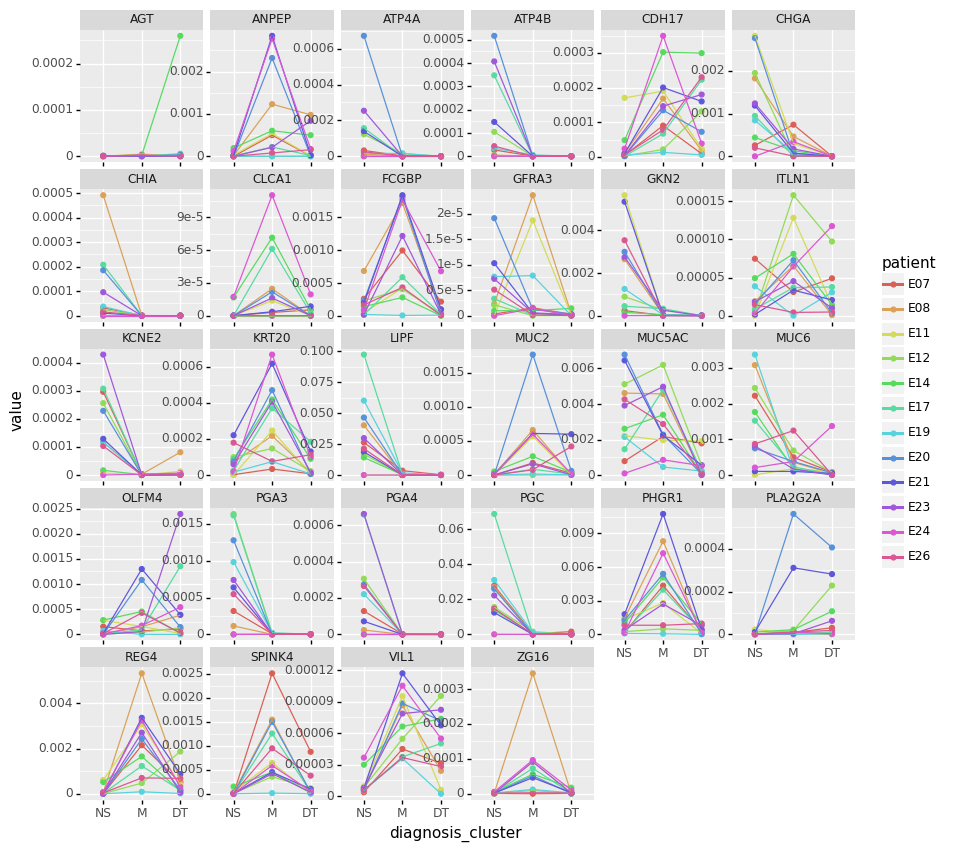

<ggplot: (8757004134377)>

In [18]:
pn.ggplot(
    DDDD.query('diagnosis_cluster !="NA" and diagnosis_cluster !="NE" '),
    pn.aes('diagnosis_cluster', 'value', group='patient', color='patient')
)+ pn.geom_point()+ pn.geom_line() + pn.facet_wrap('genename', scales='free') + pn.theme(figure_size=(10,10))

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 28 rows containing missing values.


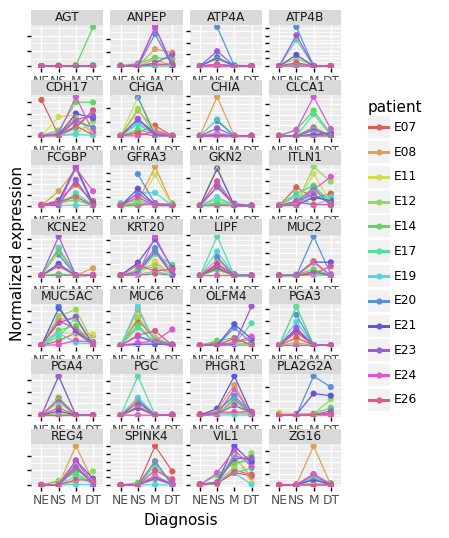

<ggplot: (8757004850557)>

In [52]:
p = pn.ggplot(
    DDDD.query('diagnosis_cluster !="NA"'),
    pn.aes('diagnosis_cluster', 'value', group='patient', color='patient')
)+ pn.geom_point()+ pn.geom_line() + pn.facet_wrap('genename', scales='free', nrow=8)\
+ pn.theme(figure_size=(4,6), axis_text_y = pn.element_blank()) + pn.labs(x='Diagnosis', y='Normalized expression')
p

In [53]:
p.save('/tmp/fading_differentiation.svg')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 4 x 6 in image.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/fading_differentiation.svg
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 28 rows containing missing values.
